In [1]:
# Configuration
MODEL_NAME = "ViT-B-32"
PRETRAINED_DATASET = "laion2b_s34b_b79k"
DEVICE_PREFERENCE = "mps"  # change to "cuda" or "cpu" if needed
SEED = 42

RUN_SPLITS = ["train", "test"]  # adjust to limit splits
LIMIT_IMAGES = 1000  # lower for quick smoke tests
BATCH_SIZE = 32
K_VALUES = (1, 5, 10)

TEXT_CHUNK_WORDS = 8  # set 0 to disable chunking
TEXT_CHUNK_STRIDE = 4
TEXT_POOLING = "mean"  # mean / max / attn
TEXT_CHUNK_THRESHOLD = 32  # captions shorter than this keep original form unless entities are used

ADAPTER_STEPS = 100
ADAPTER_LR = 1e-5
ADAPTER_LOGIT_LR = 5e-7
ADAPTER_BATCH = 32
ADAPTER_HIDDEN = 64
DISTILL_WEIGHTS = [0.0, 0.2, 0.5, 1.0]
ENTITY_PHRASE_MIN_WORDS = 2

ENTITIES_ROOT = "data/flickr30k/flickr30k_entities-master"
IMAGES_ROOT = "data/flickr30k/flickr30k-images"


In [2]:
import math
import os
import random
import sys
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

entities_python_root = Path(ENTITIES_ROOT).resolve()
if str(entities_python_root) not in sys.path:
    sys.path.append(str(entities_python_root))

from flickr30k_entities_utils import get_sentence_data  # type: ignore[import]
from adapter import attach_text_adapters, detach_text_adapters, normalize_features
from utils import (
    encode_openclip_embeddings,
    ensure_dir,
    load_flickr30k_karpathy_json,
    pool_chunk_embeddings,
    chunk_caption_words,
    recall_at_k_image_to_text,
    recall_at_k_text_to_image,
    select_torch_device,
    set_all_seeds,
)

In [3]:
# Paths, device, seeds
root = Path(os.getcwd()).resolve()
output_dir = root / "output"
ensure_dir(output_dir)
plot_dir = output_dir / "tmp"
ensure_dir(plot_dir)
device = select_torch_device(DEVICE_PREFERENCE)
set_all_seeds(SEED)
print(f"root: {root}")
print(f"output_dir: {output_dir}")
print(f"device: {device}")

root: /Users/apple/grad_material/2025 fall/comp 545/final
output_dir: /Users/apple/grad_material/2025 fall/comp 545/final/output
device: mps


In [4]:
# Reminder: make sure the annotation JSON files already exist

### CLIP model and tokenizer

In [5]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAINED_DATASET,
    device=device,
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
model.eval()

visual_module = cast(torch.nn.Module, model.visual)
for p in visual_module.parameters():
    p.requires_grad_(False)

image_transform = cast(Callable[[Image.Image], torch.Tensor], preprocess)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"trainable params: {trainable_params:,}")

trainable params: 63,428,097


In [6]:
# Load Karpathy train/test splits

def load_split(split: str) -> List[Dict[str, object]]:
    ann_path = output_dir / f"flickr30k_annotations_{split}.json"
    return load_flickr30k_karpathy_json(
        annotations_path=ann_path,
        images_root=Path(IMAGES_ROOT),
        split=split,
        limit=LIMIT_IMAGES,
    )

In [7]:
datasets: Dict[str, List[Dict[str, object]]] = {}
for split in RUN_SPLITS:
    split_data = load_split(split)
    datasets[split] = split_data
    num_caps = sum(len(cast(List[str], item["captions"])) for item in split_data)
    print(f"split={split} images={len(split_data)} captions={num_caps}")

split=train images=1000 captions=5000
split=test images=1000 captions=5000


In [8]:
def build_entity_phrase_cache(dataset: List[Dict[str, object]]) -> Dict[str, List[Dict[str, object]]]:
    cache: Dict[str, List[Dict[str, object]]] = {}
    sentences_root = Path(ENTITIES_ROOT) / "annotations" / "Sentences"
    for item in dataset:
        image_path = Path(str(item["image_path"]))
        image_id = image_path.stem
        sentence_file = sentences_root / f"{image_id}.txt"
        if sentence_file.is_file():
            try:
                cache[image_id] = get_sentence_data(str(sentence_file))
            except Exception:
                cache[image_id] = []
        else:
            cache[image_id] = []
    return cache

In [9]:
def deduplicate_preserve_order(items: List[str]) -> List[str]:
    seen = set()
    ordered: List[str] = []
    for item in items:
        key = item.strip()
        if not key:
            continue
        norm = key.lower()
        if norm in seen:
            continue
        seen.add(norm)
        ordered.append(key)
    return ordered

In [10]:
def build_semantic_segments(
    image_id: str,
    caption_idx: int,
    caption: str,
    entity_cache: Dict[str, List[Dict[str, object]]],
) -> List[str]:
    caption = caption.strip()
    words = caption.split()
    segments: List[str] = []
    if TEXT_CHUNK_WORDS > 0 and len(words) >= TEXT_CHUNK_THRESHOLD:
        segments.extend(
            chunk_caption_words(
                caption,
                TEXT_CHUNK_WORDS,
                TEXT_CHUNK_STRIDE,
            )
        )

    sentence_data = entity_cache.get(image_id)
    if sentence_data and caption_idx < len(sentence_data):
        sentence_entry = sentence_data[caption_idx]
        phrase_entries = cast(List[Dict[str, Any]], sentence_entry.get("phrases", []))
        attribute_phrases = [
            str(p.get("phrase", "")).strip()
            for p in phrase_entries
            if len(str(p.get("phrase", "")).split()) >= ENTITY_PHRASE_MIN_WORDS
        ]
        if attribute_phrases:
            if not segments:
                segments.extend(attribute_phrases)
            else:
                segments.extend(attribute_phrases)

    if not segments:
        segments = [caption]
    else:
        if caption not in segments:
            segments.append(caption)
    return deduplicate_preserve_order(segments)


In [11]:
def encode_chunked_embeddings(
    split: str,
    entity_cache: Dict[str, List[Dict[str, object]]],
    *,
    progress_desc: str,
) -> Dict[str, object]:
    if progress_desc:
        print(f"encoding {progress_desc}...")
    dataset = datasets[split]
    image_paths = [str(item["image_path"]) for item in dataset]

    image_embeddings: List[torch.Tensor] = []
    for start in range(0, len(image_paths), BATCH_SIZE):
        batch_paths = image_paths[start:start + BATCH_SIZE]
        images: List[torch.Tensor] = []
        for path in batch_paths:
            with Image.open(path).convert("RGB") as img:
                images.append(image_transform(img))
        image_tensor = torch.stack(images, dim=0).to(device)
        with torch.no_grad():
            feats = model.encode_image(image_tensor).float()  # type: ignore[attr-defined]
        image_embeddings.append(normalize_features(feats).cpu())
    image_embed_tensor = torch.cat(image_embeddings, dim=0)

    caption_info: List[Tuple[int, int, int]] = []  # (image_idx, start, end)
    segment_texts: List[str] = []
    for image_idx, item in enumerate(dataset):
        image_id = Path(str(item["image_path"])).stem
        captions = cast(List[str], item["captions"])
        for caption_idx, caption in enumerate(captions):
            segments = build_semantic_segments(image_id, caption_idx, caption, entity_cache)
            start = len(segment_texts)
            segment_texts.extend(segments)
            end = len(segment_texts)
            caption_info.append((image_idx, start, end))

    if not segment_texts:
        raise RuntimeError("No segments generated for chunked encoding")

    segment_embeds: List[torch.Tensor] = []
    for start in range(0, len(segment_texts), BATCH_SIZE):
        texts = segment_texts[start:start + BATCH_SIZE]
        tokens = tokenizer(texts).to(device)
        with torch.no_grad():
            feats = model.encode_text(tokens).float()  # type: ignore[attr-defined]
        segment_embeds.append(normalize_features(feats).cpu())
    segment_matrix = torch.cat(segment_embeds, dim=0)

    caption_embeddings: List[np.ndarray] = []
    caption_to_image_index: List[int] = []
    image_to_caption_indices: List[List[int]] = []

    caption_ptr = 0
    for image_idx, item in enumerate(dataset):
        indices: List[int] = []
        captions = cast(List[str], item["captions"])
        for _ in captions:
            img_idx, start, end = caption_info[caption_ptr]
            chunk_tensor = segment_matrix[start:end]
            pooled = pool_chunk_embeddings(chunk_tensor, mode=TEXT_POOLING)
            caption_embeddings.append(pooled.cpu().numpy())
            caption_to_image_index.append(img_idx)
            indices.append(len(caption_embeddings) - 1)
            caption_ptr += 1
        image_to_caption_indices.append(indices)

    if caption_ptr != len(caption_info):
        raise RuntimeError("Caption pointer did not consume all segment info")

    return {
        "image_embeddings": image_embed_tensor.numpy(),
        "caption_embeddings": np.asarray(caption_embeddings, dtype=np.float32),
        "caption_to_image_index": np.asarray(caption_to_image_index, dtype=np.int64),
        "image_to_caption_indices": image_to_caption_indices,
    }



In [12]:

entity_caches: Dict[str, Dict[str, List[Dict[str, object]]]] = {}
if TEXT_CHUNK_WORDS > 0:
    print("building entity phrase caches...")
    for split, data in datasets.items():
        entity_caches[split] = build_entity_phrase_cache(data)
else:
    for split in datasets:
        entity_caches[split] = {}

building entity phrase caches...


### Encode baseline CLIP features (run once per configuration)

In [13]:
def run_clip_encoding(
    split: str,
    pooling: Optional[str] = None,
    chunk_words: Optional[int] = None,
    chunk_stride: Optional[int] = None,
) -> Dict[str, object]:
    words = chunk_words if chunk_words and chunk_words > 0 else None
    stride = chunk_stride if chunk_stride and chunk_stride > 0 else None
    if words is not None:
        threshold = TEXT_CHUNK_THRESHOLD if TEXT_CHUNK_THRESHOLD > 0 else 0
    else:
        threshold = 10_000  # effectively disable chunking
    return encode_openclip_embeddings(
        dataset=datasets[split],
        preprocess=preprocess,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        text_chunk_words=words,
        text_chunk_stride=stride,
        text_pooling=pooling or TEXT_POOLING,
        progress=True,
        progress_desc=f"{split}|chunk{words or 0}_{pooling or TEXT_POOLING}",
        chunk_threshold_tokens=threshold,
    )

In [14]:
def compute_recalls(embeddings: Dict[str, object]) -> Dict[str, Dict[int, float]]:
    img = np.asarray(embeddings["image_embeddings"], dtype=np.float32)
    cap = np.asarray(embeddings["caption_embeddings"], dtype=np.float32)
    cap2img = np.asarray(embeddings["caption_to_image_index"], dtype=np.int64)
    img2cap = cast(List[List[int]], embeddings["image_to_caption_indices"])
    return {
        "t2i": recall_at_k_text_to_image(img, cap, cap2img, ks=K_VALUES),
        "i2t": recall_at_k_image_to_text(img, cap, img2cap, ks=K_VALUES),
    }

In [15]:
baseline_original_embeddings: Dict[str, Dict[str, object]] = {}
baseline_original_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}

In [16]:
# computing original CLIP baseline (no chunk)
for split in RUN_SPLITS:
    emb_orig = run_clip_encoding(
        split,
        pooling="mean",
        chunk_words=0,
        chunk_stride=0,
    )
    metrics_orig = compute_recalls(emb_orig)
    baseline_original_embeddings[split] = emb_orig
    baseline_original_metrics[split] = metrics_orig
    print(f"baseline original {split}:")
    for tag in ("t2i", "i2t"):
        for k in K_VALUES:
            print(f"  {tag}@{k}: {metrics_orig[tag][k] * 100:.2f}")

chunk_baseline_embeddings: Dict[str, Dict[str, object]] = {}
chunk_baseline_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}

if TEXT_CHUNK_WORDS > 0:
    print("computing chunked baseline (no adapter)...")
    for split in RUN_SPLITS:
        emb_chunk = encode_chunked_embeddings(
            split,
            entity_caches[split],
            progress_desc=f"{split}|chunk-baseline",
        )
        metrics_chunk = compute_recalls(emb_chunk)
        chunk_baseline_embeddings[split] = emb_chunk
        chunk_baseline_metrics[split] = metrics_chunk
        print(f"baseline chunk {split}:")
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                print(f"  {tag}@{k}: {metrics_chunk[tag][k] * 100:.2f}")
else:
    chunk_baseline_embeddings = baseline_original_embeddings
    chunk_baseline_metrics = baseline_original_metrics


train|chunk0_mean:   0%|          | 0/32 [00:00<?, ?it/s]

train|chunk0_mean:   0%|          | 0/79 [00:00<?, ?it/s]

baseline original train:
  t2i@1: 68.70
  t2i@5: 89.76
  t2i@10: 94.06
  i2t@1: 85.60
  i2t@5: 97.00
  i2t@10: 98.60


test|chunk0_mean:   0%|          | 0/32 [00:00<?, ?it/s]

test|chunk0_mean:   0%|          | 0/79 [00:00<?, ?it/s]

baseline original test:
  t2i@1: 69.76
  t2i@5: 89.68
  t2i@10: 93.76
  i2t@1: 84.50
  i2t@5: 96.00
  i2t@10: 98.50
computing chunked baseline (no adapter)...
encoding train|chunk-baseline...
baseline chunk train:
  t2i@1: 56.62
  t2i@5: 81.52
  t2i@10: 88.46
  i2t@1: 72.10
  i2t@5: 92.30
  i2t@10: 96.10
encoding test|chunk-baseline...
baseline chunk test:
  t2i@1: 57.08
  t2i@5: 81.66
  t2i@10: 88.78
  i2t@1: 71.40
  i2t@5: 92.70
  i2t@10: 96.30


original baseline
metric  i2t@1  i2t@10  i2t@5  t2i@1  t2i@10  t2i@5
split                                             
test     84.5    98.5   96.0  69.76   93.76  89.68
train    85.6    98.6   97.0  68.70   94.06  89.76


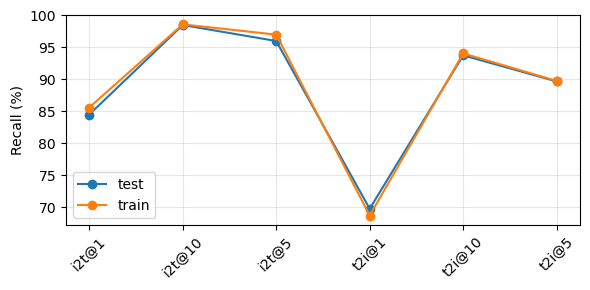

chunk baseline
metric  i2t@1  i2t@10  i2t@5  t2i@1  t2i@10  t2i@5
split                                             
test     71.4    96.3   92.7  57.08   88.78  81.66
train    72.1    96.1   92.3  56.62   88.46  81.52


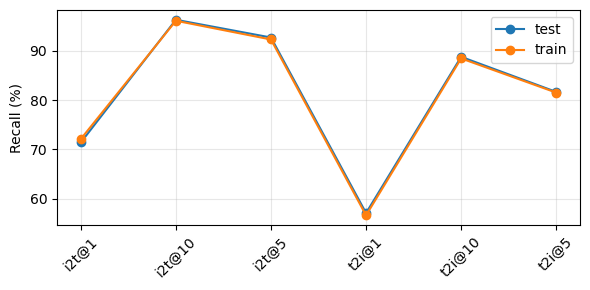

In [17]:
# Optional: visualize baseline recall numbers
baseline_rows: List[Dict[str, object]] = []

def append_rows(metrics: Dict[str, Dict[str, Dict[int, float]]], label: str) -> None:
    for split, metric in metrics.items():
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                baseline_rows.append(
                    {
                        "variant": label,
                        "split": split,
                        "metric": f"{tag}@{k}",
                        "recall": metric[tag][k] * 100.0,
                    }
                )


append_rows(baseline_original_metrics, "original")
if TEXT_CHUNK_WORDS > 0:
    append_rows(chunk_baseline_metrics, "chunk")

baseline_df = pd.DataFrame(baseline_rows)

for variant in baseline_df["variant"].unique():
    pivot = baseline_df[baseline_df["variant"] == variant].pivot(
        index="split",
        columns="metric",
        values="recall",
    )
    print(f"{variant} baseline\n{pivot}")
    fig, ax = plt.subplots(figsize=(6, 3))
    for split in pivot.index:
        ax.plot(pivot.columns, pivot.loc[split], marker="o", label=split)
    ax.set_ylabel("Recall (%)")
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    # fig.savefig(plot_dir / f"baseline_{variant}.png")
    # plt.close(fig)
    plt.show()

In [18]:
# Adapter training and evaluation across distillation weights
teacher_caps_full: Optional[torch.Tensor] = None
teacher_img2cap_full: Optional[List[List[int]]] = None
if any(w > 0 for w in DISTILL_WEIGHTS):
    teacher_source = chunk_baseline_embeddings if TEXT_CHUNK_WORDS > 0 else baseline_original_embeddings
    teacher_caps_full = normalize_features(
        torch.tensor(
            teacher_source["train"]["caption_embeddings"],
            dtype=torch.float32,
        device=device,
        )
    )
    teacher_img2cap_full = cast(
        List[List[int]],
        teacher_source["train"]["image_to_caption_indices"],
    )

results_summary: List[Dict[str, object]] = []

In [19]:
for distill_weight in DISTILL_WEIGHTS:
    print(f"\n=== distill_weight={distill_weight} ===")

    detach_text_adapters(model)
    adapter = attach_text_adapters(model, ADAPTER_HIDDEN)
    model.to(device)
    model.eval()

    for p in model.parameters():
        p.requires_grad_(False)
    for p in adapter.parameters():
        p.requires_grad_(True)

    logit_scale = cast(torch.nn.Parameter, model.logit_scale)
    logit_scale.requires_grad_(True)

    adapter_params = [p for p in adapter.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(
        [
            {"params": adapter_params, "lr": ADAPTER_LR, "weight_decay": 1e-4},
            {"params": [logit_scale], "lr": ADAPTER_LOGIT_LR, "weight_decay": 0.0},
        ]
    )

    teacher_caps = teacher_caps_full if distill_weight > 0 else None
    teacher_img2cap = teacher_img2cap_full if distill_weight > 0 else None

    train_indices = list(range(len(datasets["train"])))
    loss_log: List[Tuple[int, float, float]] = []

    for step in range(ADAPTER_STEPS):
        batch_idx = random.sample(train_indices, k=min(ADAPTER_BATCH, len(train_indices)))
        captions: List[str] = []
        images: List[torch.Tensor] = []
        caption_segments: List[str] = []
        caption_spans: List[Tuple[int, int]] = []
        teacher_pick: List[int] = []
        for idx in batch_idx:
            entry = datasets["train"][idx]
            caption_list = cast(List[str], entry["captions"])
            cap_pos = random.randrange(len(caption_list))
            selected_caption = caption_list[cap_pos]
            captions.append(selected_caption)
            image_path = Path(str(entry["image_path"]))
            with Image.open(image_path).convert("RGB") as img:
                images.append(image_transform(img))

            image_id = image_path.stem
            segments = build_semantic_segments(image_id, cap_pos, selected_caption, entity_caches["train"])
            start = len(caption_segments)
            caption_segments.extend(segments)
            caption_spans.append((start, len(caption_segments)))

            if teacher_img2cap is not None:
                teacher_pick.append(teacher_img2cap[idx][cap_pos])

        image_tensor = torch.stack(images, dim=0).to(device)
        with torch.no_grad():
            encoded_images = model.encode_image(image_tensor).float()  # type: ignore[attr-defined]
        image_features = normalize_features(encoded_images)

        if not caption_segments:
            raise RuntimeError("No caption segments generated for training batch")

        segment_tokens = tokenizer(caption_segments).to(device)
        segment_embeds = model.encode_text(segment_tokens).float()  # type: ignore[attr-defined]
        segment_embeds = normalize_features(segment_embeds)
        pooled_text: List[torch.Tensor] = []
        for start, end in caption_spans:
            pooled_text.append(pool_chunk_embeddings(segment_embeds[start:end], mode=TEXT_POOLING))
        text_features = torch.stack(pooled_text, dim=0)

        logits = (text_features @ image_features.t()) * logit_scale.exp()
        targets = torch.arange(logits.size(0), device=device)
        loss = (F.cross_entropy(logits, targets) + F.cross_entropy(logits.t(), targets)) * 0.5

        if teacher_caps is not None and teacher_pick:
            idx_tensor = torch.tensor(teacher_pick, dtype=torch.long, device=device)
            teacher_batch = teacher_caps[idx_tensor]
            loss = loss + distill_weight * F.mse_loss(text_features, teacher_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(adapter_params + [logit_scale], max_norm=1.0)
        optimizer.step()
        logit_scale.data.clamp_(min=math.log(1 / 20), max=math.log(50))

        if step % 10 == 0 or step == ADAPTER_STEPS - 1:
            loss_log.append((step, float(loss.item()), float(logit_scale.exp().item())))
            print(f"step {step:03d} loss={loss.item():.4f} scale={logit_scale.exp().item():.2f}")

    if loss_log:
        steps, losses, scales = zip(*loss_log)
        fig, ax1 = plt.subplots(figsize=(6, 3))
        ax1.plot(steps, losses, marker="o", label="loss")
        ax1.set_ylabel("loss")
        ax2 = ax1.twinx()
        ax2.plot(steps, scales, color="orange", label="scale")
        ax2.set_ylabel("logit scale")
        ax1.set_xlabel("step")
        ax1.grid(alpha=0.3)
        fig.legend(loc="upper right")
        plt.tight_layout()
        fig.savefig(plot_dir / f"loss_distill_{distill_weight:.2f}.png")
        plt.close(fig)

    adapter_metrics: Dict[str, Dict[str, Dict[int, float]]] = {}
    for split in RUN_SPLITS:
        if TEXT_CHUNK_WORDS > 0:
            emb = encode_chunked_embeddings(
                split,
                entity_caches[split],
                progress_desc=f"{split}|adapter_{distill_weight}",
            )
        else:
            emb = run_clip_encoding(
                split,
                pooling="mean",
                chunk_words=0,
                chunk_stride=0,
            )
        metrics = compute_recalls(emb)
        adapter_metrics[split] = metrics
        print(f"adapter (distill={distill_weight}) {split}:")
        for tag in ("t2i", "i2t"):
            for k in K_VALUES:
                print(f"  {tag}@{k}: {metrics[tag][k] * 100:.2f}")

    for tag in ("t2i", "i2t"):
        for k in K_VALUES:
            results_summary.append(
                {
                    "distill": distill_weight,
                    "metric": f"{tag}@{k}",
                    "adapter": adapter_metrics["test"][tag][k] * 100.0,
                    "baseline_original": baseline_original_metrics["test"][tag][k] * 100.0,
                    "baseline_chunk": chunk_baseline_metrics["test"][tag][k] * 100.0,
                }
            )

    detach_text_adapters(model)
    logit_scale.requires_grad_(False)


=== distill_weight=0.0 ===
step 000 loss=0.3303 scale=50.00
step 010 loss=0.5545 scale=50.00
step 020 loss=0.3032 scale=50.00
step 030 loss=0.3183 scale=50.00
step 040 loss=0.3028 scale=50.00
step 050 loss=0.2360 scale=50.00
step 060 loss=0.2743 scale=50.00
step 070 loss=0.3621 scale=50.00
step 080 loss=0.5101 scale=50.00
step 090 loss=0.1169 scale=50.00
step 099 loss=0.3129 scale=50.00
encoding train|adapter_0.0...
adapter (distill=0.0) train:
  t2i@1: 61.80
  t2i@5: 85.58
  t2i@10: 91.64
  i2t@1: 74.10
  i2t@5: 93.20
  i2t@10: 96.90
encoding test|adapter_0.0...
adapter (distill=0.0) test:
  t2i@1: 61.50
  t2i@5: 85.42
  t2i@10: 91.04
  i2t@1: 73.50
  i2t@5: 93.40
  i2t@10: 96.90

=== distill_weight=0.2 ===
step 000 loss=0.5486 scale=50.00
step 010 loss=0.6030 scale=50.00
step 020 loss=0.5105 scale=50.00
step 030 loss=0.3106 scale=50.00
step 040 loss=0.4783 scale=50.00
step 050 loss=0.2036 scale=50.00
step 060 loss=0.5678 scale=50.00
step 070 loss=0.2730 scale=50.00
step 080 loss=0.3

In [20]:
summary_df = pd.DataFrame(results_summary)
print("\nSummary (test split):")
print(
    summary_df.pivot_table(
        index="metric",
        columns="distill",
        values="adapter",
    )
)


Summary (test split):
distill    0.0    0.2    0.5    1.0
metric                             
i2t@1    73.50  72.90  72.70  72.90
i2t@10   96.90  96.90  96.70  97.10
i2t@5    93.40  93.40  93.50  93.50
t2i@1    61.50  61.54  61.30  61.58
t2i@10   91.04  90.90  90.84  90.86
t2i@5    85.42  85.64  85.76  85.44


In [21]:
metrics_order = sorted(summary_df["metric"].unique())
variant_to_values: Dict[str, List[float]] = {}

In [22]:
def extract_metric_values(metric_source: Dict[str, Dict[int, float]]) -> List[float]:
    values: List[float] = []
    for metric in metrics_order:
        tag, k_str = metric.split("@")
        values.append(metric_source[tag][int(k_str)] * 100.0)
    return values

In [23]:
variant_to_values["baseline_original"] = extract_metric_values(baseline_original_metrics["test"])
variant_to_values["baseline_chunk"] = extract_metric_values(chunk_baseline_metrics["test"])

In [24]:
for weight in DISTILL_WEIGHTS:
    adapter_rows = summary_df[summary_df["distill"] == weight]
    adapter_map = {row["metric"]: float(row["adapter"]) for _, row in adapter_rows.iterrows()}
    variant_to_values[f"adapter_{weight:.2f}"] = [adapter_map[m] for m in metrics_order]

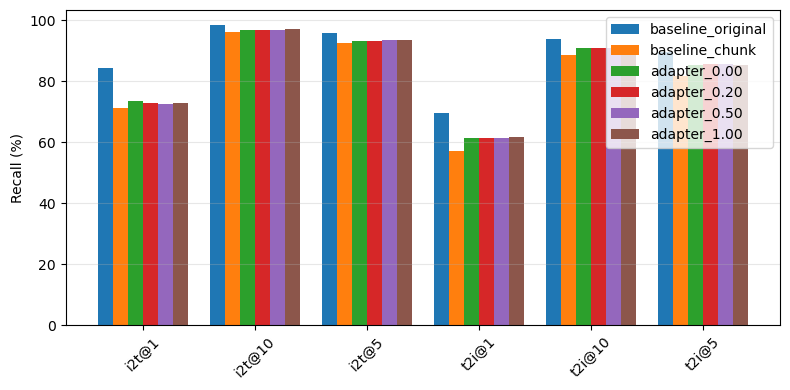

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(metrics_order))
total_variants = len(variant_to_values)
width = min(0.8 / total_variants, 0.15)

for idx, (label, values) in enumerate(variant_to_values.items()):
    offset = (idx - (total_variants - 1) / 2) * width
    ax.bar(x + offset, values, width, label=label)

ax.set_xticks(x)
ax.set_xticklabels(metrics_order, rotation=45)
ax.set_ylabel("Recall (%)")
ax.grid(alpha=0.3, axis="y")
ax.legend()
plt.tight_layout()
# fig.savefig(plot_dir / "comparison_all.png")
plt.show()

summary_path = plot_dir / "results_summary.csv"
summary_df.to_csv(summary_path, index=False)
